# Elo Merchant Category Recommendation - Transactions distribution <a class="tocSkip">
*End date: 2019. february 19.*

This tutorial notebook is the first part of a seriers for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [46]:
import os
import gc
import math
import scipy
import random
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.mlab import normpdf
from IPython.core.display import display, HTML
from statsmodels.graphics.gofplots import qqplot

warnings.filterwarnings("ignore")

random.seed(1)

sns.set(rc={'figure.figsize':(15, 8)})

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def displayDataInHTMLTable(columns, rows, df):
    html = '<table>'
    html+= '<thead><tr><th>&nbsp;</th>'
    for col_item in columns:
        html+= '<th>' + str(col_item) + '</th>'
    html+= '</tr></thead><tbody>'

    for x in range(0, len(df)):
        html+= '<tr>'
        html+= '<td><b>' + rows[x] + '</b></td>'

        for y in range(0, len(df[0])):
            html+= '<td>' + df[x][y] + '</td>'
    html+= '</tr>'

    html+= '</tbody></table>'
    display(HTML(html))

In [126]:
def create_date_features(df, source_column, preposition):
    df[preposition + '_year'] = df[source_column].dt.year
    df[preposition + '_month'] = df[source_column].dt.month
    df[preposition + '_day'] = df[source_column].dt.day
    df[preposition + '_hour'] = df[source_column].dt.hour
    df[preposition + '_weekofyear'] = df[source_column].dt.weekofyear
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    df[preposition + '_quarter'] = df[source_column].dt.quarter
    
    return df

## Users with a large number of transactions
In section 2.2 of *1.1_Descriptives* file, we see that the maximum number of transactions per user in the train set is much larger than the mean value. We will try to identify these users to check if they have a significative impact in the prediction.

In [4]:
df_hist_trans = pd.read_csv("input/historical_transactions.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.7% reduction)


In [5]:
df_hist_trans[:3]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37


In [6]:
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv")
df_new_trans = reduce_mem_usage(df_new_trans)

Starting memory usage: 209.67 MB
Reduced memory usage: 114.20 MB (45.5% reduction)


In [104]:
df_train = pd.read_csv("input/train.csv", parse_dates=["first_active_month"])
df_train = reduce_mem_usage(df_train)
print("{:,} observations and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
201,917 observations and 6 features in train set.


In [105]:
df_test = pd.read_csv("input/test.csv", parse_dates=["first_active_month"])
df_test = reduce_mem_usage(df_test)
print("{:,} observations and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)
123,623 observations and 5 features in test set.


In [7]:
df_new_trans.head(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14


In [8]:
df_n = df_new_trans.groupby("card_id").size().reset_index().rename({0:'transactions'}, axis=1)
df_h = df_hist_trans.groupby("card_id").size().reset_index().rename({0:'transactions'}, axis=1)

displayDataInHTMLTable(
    ['Average', 'Maximum'],
    ['New transactions', 'Historical transactions'],
    [
        ['{:.4f}'.format(df_n['transactions'].mean()), '{}'.format(df_n['transactions'].max())],
        ['{:.4f}'.format(df_h['transactions'].mean()), '{}'.format(df_h['transactions'].max())]
    ]
)

,Average,Maximum
New transactions,6.7690,109
Historical transactions,89.4279,5582


We see that the averages of amount of transactions are quite different between train and test. There might be a few cards with a large amount of tranactions that distort the average.

In [9]:
df_n[:3]

,card_id,transactions
0,C_ID_00007093c1,2
1,C_ID_0001238066,26
2,C_ID_0001506ef0,2


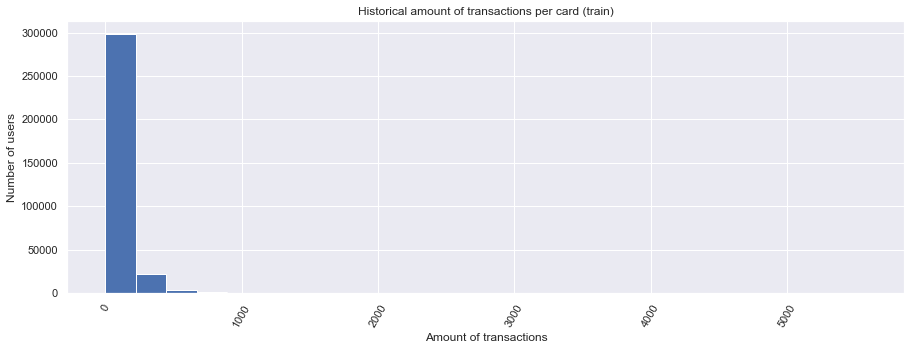

In [47]:
plt.figure(figsize=(15, 5))
plt.hist(df_h['transactions'].values, bins=25)
plt.title('Historical amount of transactions per card (train)')
plt.xlabel('Amount of transactions')
plt.xticks(rotation=60)
plt.ylabel('Number of users')
plt.show()

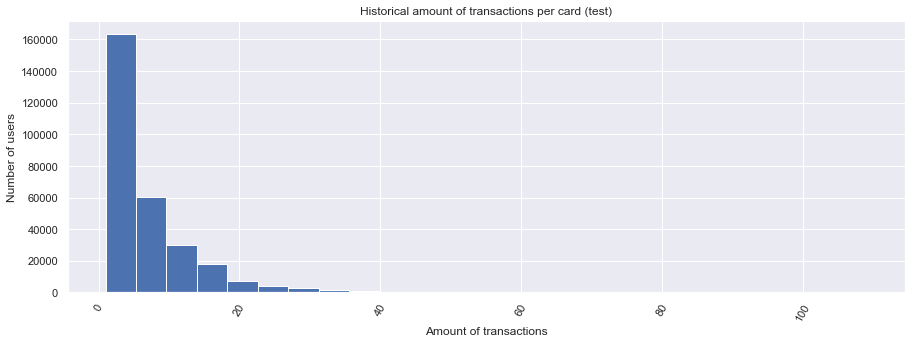

In [48]:
plt.figure(figsize=(15, 5))
plt.hist(df_n['transactions'].values, bins=25)
plt.title('Historical amount of transactions per card (test)')
plt.xlabel('Amount of transactions')
plt.xticks(rotation=60)
plt.ylabel('Number of users')
plt.show()

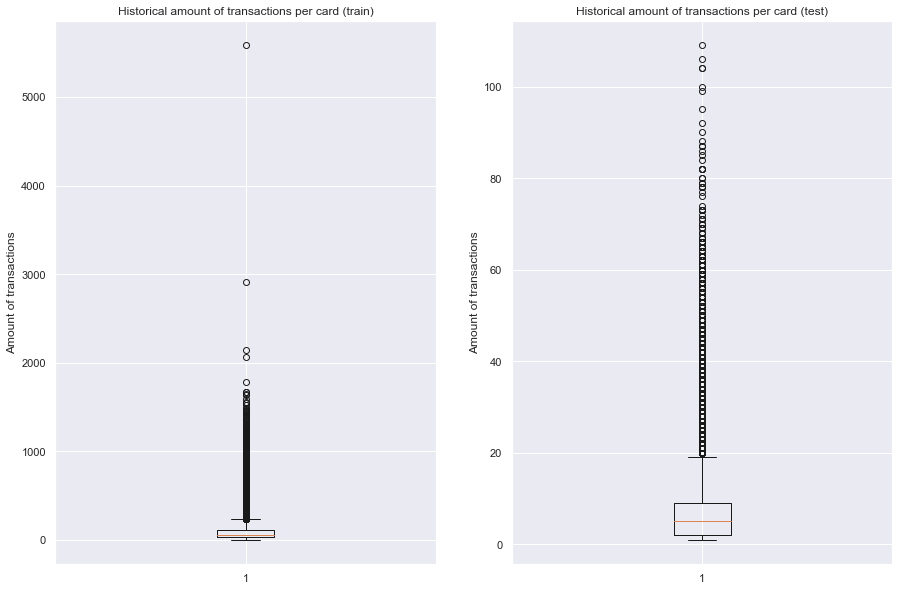

In [49]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.boxplot(df_h['transactions'].values)
plt.title('Historical amount of transactions per card (train)')
plt.ylabel('Amount of transactions')

plt.subplot(1, 2, 2)
plt.boxplot(df_n['transactions'].values)
plt.title('Historical amount of transactions per card (test)')
plt.ylabel('Amount of transactions')
plt.show()

We see that the amounts of transactions in train and test sets do not seem to follow the same distribution. According to the descriptive results, the purchasing dates for both sets are in the same range. However, it could be that, in general, the new transactions correspond to "newer" users which still didn't have time to generate a lot of transactions.
Besides, there are a couple of users in the historical set that may be (even more) outliers.

### Distribution of number of transactions over time

In [13]:
def create_date_year_month(df, source_column, preposition):
    df[preposition + '_ym'] = df[source_column].dt.strftime('%Y') + '-' + df[source_column].dt.strftime('%m')    
    return df

In [14]:
df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])
df_hist_trans = create_date_year_month(df_hist_trans, 'purchase_date', 'purchase')

In [15]:
df_new_trans['purchase_date'] = pd.to_datetime(df_new_trans['purchase_date'])
df_new_trans = create_date_year_month(df_new_trans, 'purchase_date', 'purchase')

In [16]:
df_new_trans.head(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_ym
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19,2018-03
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19,2018-03
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14,2018-04


In [17]:
df_h_ym = df_hist_trans.groupby('purchase_ym').size().reset_index().rename({0:'transactions'}, axis=1)

In [18]:
df_n_ym = df_new_trans.groupby('purchase_ym').size().reset_index().rename({0:'transactions'}, axis=1)

Text(0,0.5,'Amount of transactions')

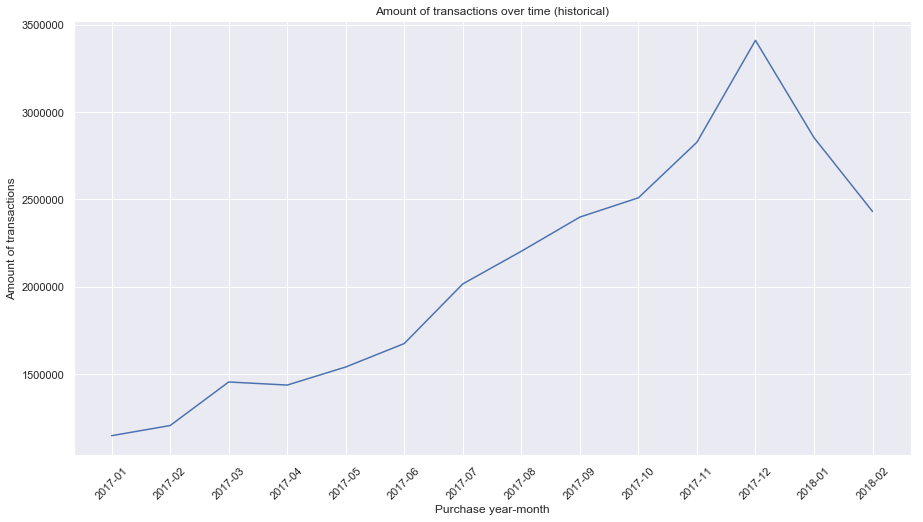

In [50]:
ax = sns.lineplot(x=df_h_ym['purchase_ym'], y=df_h_ym['transactions'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Amount of transactions over time (historical)')
ax.set_xlabel('Purchase year-month')
ax.set_ylabel('Amount of transactions')

Text(0,0.5,'Amount of transactions')

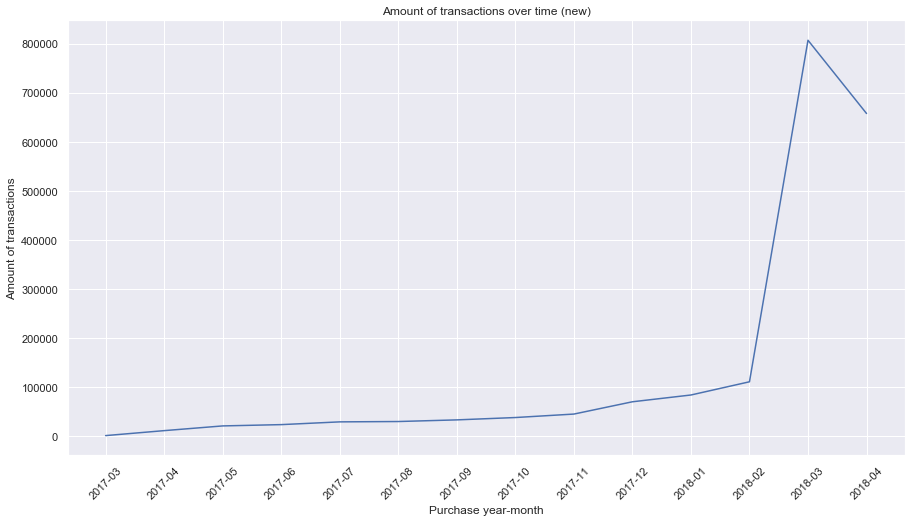

In [51]:
ax = sns.lineplot(x=df_n_ym['purchase_ym'], y=df_n_ym['transactions'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Amount of transactions over time (new)')
ax.set_xlabel('Purchase year-month')
ax.set_ylabel('Amount of transactions')

It seems that the transactions in the test file are rather new. Let's check how many users do not have transactions in this data set before January 2018.

In [21]:
nu = len(df_new_trans[df_new_trans['purchase_ym']>'2018-01']['card_id'].unique())
nt = len(df_new_trans['card_id'].unique())
print("Percentage of users in the new transactions set without transactions before 2018-01: {:.2f}%".format(nu/nt*100))

Percentage of users in the new transactions set without transactions before 2018-01: 82.68%


### Distribution of the number of transactions over merchants

In [68]:
df_merch_h = df_hist_trans.groupby('merchant_id').size().reset_index().rename({0:'transactions'}, axis=1).sort_values(by=['transactions'], ascending=False)

In [59]:
df_merch_n = df_new_trans.groupby('merchant_id').size().reset_index().rename({0:'transactions'}, axis=1).sort_values(by=['transactions'], ascending=False)

In [96]:
df_merch_h[:5]

,merchant_id,transactions
835,M_ID_00a6ca8a8a,1115097
292163,M_ID_e5374dabc0,428619
185292,M_ID_9139332ccc,361385
103025,M_ID_50f575c681,183894
321840,M_ID_fc7d7969c3,177040


In [99]:
df_hist_trans = df_hist_trans.merge(df_merch_h, how='left', on='merchant_id')

In [103]:
df_new_trans = df_new_trans.merge(df_merch_n, how='left', on='merchant_id')

In [106]:
df_train = df_train.merge(df_hist_trans, on='card_id', how='left')

In [107]:
df_test = df_test.merge(df_new_trans, on='card_id', how='left')

In [108]:
df_train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,authorized_flag,city_id,category_1,installments,...,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_ym,transactions
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,Y,69,N,0,...,195,M_ID_cc72dac895,-3,-0.506033,2017-11-25 16:37:11,1.0,9,34,2017-11,17525.0
1,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,Y,69,N,0,...,278,M_ID_c9c0f1cb3f,-7,-0.722114,2017-07-16 12:21:00,1.0,9,37,2017-07,537.0
2,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,Y,69,N,0,...,683,M_ID_36f9e41993,-6,-0.726171,2017-08-10 21:01:16,1.0,9,34,2017-08,3116.0


In [120]:
print('There are {:,} unique records with more than 50,000 transactions.'.format(
    df_train[df_train['transactions'] > 50000]['target'].nunique()
))

There are 18,823 unique records with more than 50,000 transactions


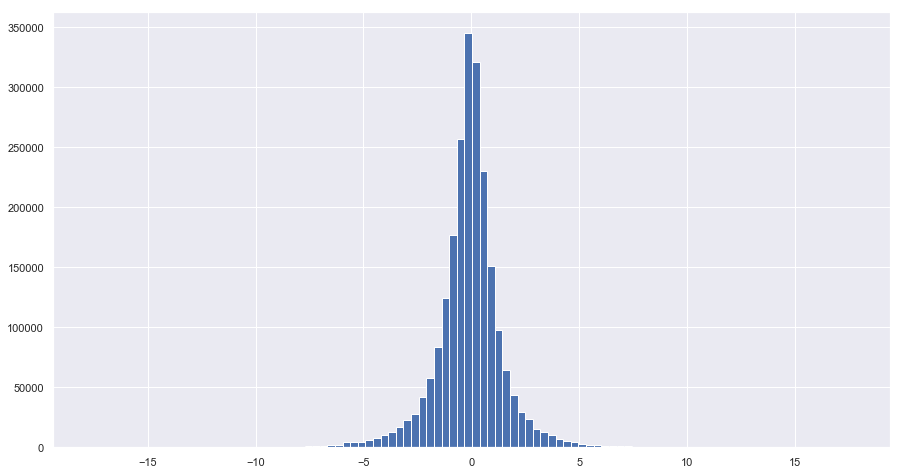

In [119]:
df_train[(df_train['transactions'] > 50000) & (df_train['target'] > -30)]['target'].hist(bins=100)

In [127]:
df_train = create_date_features(df_train, 'first_active_month', 'fam')

In [128]:
df_test = create_date_features(df_test, 'first_active_month', 'fam')

#### Select highly correlated features

In [129]:
corr_matrix = df_train.corr().abs()

In [130]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [131]:
correlated_features = [column for column in upper.columns if any(upper[column] > 0.90)]
len(correlated_features)

1

In [132]:
correlated_features

['fam_quarter']

### Overlaping of transactions between train and test

In [22]:
df_cards = pd.read_csv("input/train.csv")
df_cards.head(3)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056


In [23]:
df_cards_test = pd.read_csv("input/test.csv")
df_cards_test.head(3)

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1


In [24]:
df_hist_in_test = df_hist_trans[df_hist_trans['card_id'].isin(df_cards_test['card_id'])]
print("Percentage of historical transactions corresponding to test cards: {:.2f}%".format(df_hist_in_test.shape[0]/df_hist_trans.shape[0]*100))

Percentage of historical transactions corresponding to test cards: 38.07%


In [25]:
df_new_in_train = df_new_trans[df_new_trans['card_id'].isin(df_cards['card_id'])]
print("Percentage of new transactions corresponding to train cards: {:.2f}%".format(df_new_in_train.shape[0]/df_new_trans.shape[0]*100))

Percentage of new transactions corresponding to train cards: 62.13%


It seems that the transactions have been just divided into "historical" and "new" taking into account the date of the transaction (more or less).

### Analyze the couple of outliers in the historical set

In [26]:
id = df_h[df_h['transactions']>5000]['card_id'].values[0]
print('Card ID corresponding with more than 5000 transactions: ' + id)
print('Available information in the train cards data set:')
df_cards[df_cards['card_id']==id]

Card ID corresponding with more than 5000 transactions: C_ID_3d3dfdc692
Available information in the train cards data set:


,first_active_month,card_id,feature_1,feature_2,feature_3,target


In [27]:
print('Available information in the test cards data set:')
df_cards_test[df_cards_test['card_id']==id]

Available information in the test cards data set:


,first_active_month,card_id,feature_1,feature_2,feature_3
78729,2017-02,C_ID_3d3dfdc692,1,1,0


That is, **the bigger amount of transactions in the historical set correspond to a card in the test data set...**

Text(0,0.5,'Amount of transactions')

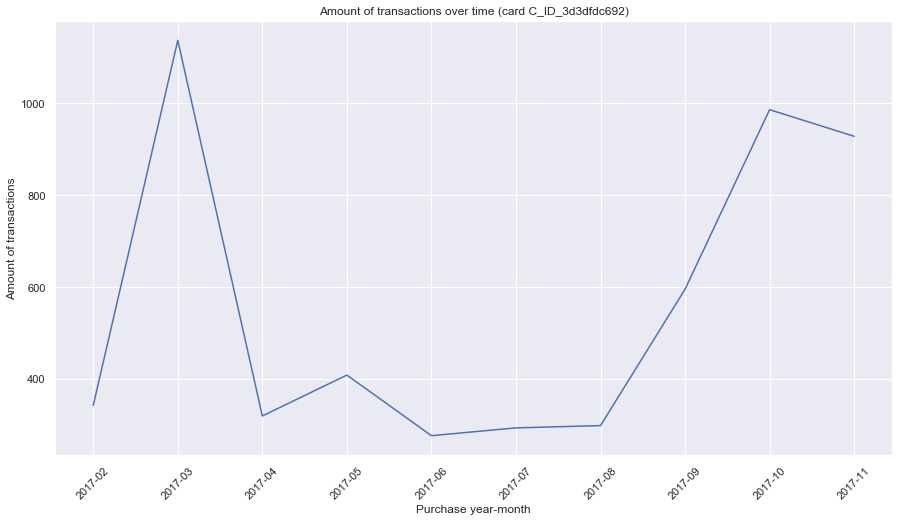

In [52]:
df_out_nt = df_hist_trans[df_hist_trans['card_id']==id].groupby('purchase_ym').size().reset_index().rename({0:'transactions'}, axis=1)
ax = sns.lineplot(x=df_out_nt['purchase_ym'], y=df_out_nt['transactions'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Amount of transactions over time (card ' + id + ')')
ax.set_xlabel('Purchase year-month')
ax.set_ylabel('Amount of transactions')

In [29]:
id2 = df_h[(df_h['transactions']>2500) & (df_h['transactions']<5000)]['card_id'].values[0]
print('Card ID corresponding with around 3000 transactions: ' + id2)
print('Available information in the cards data set:')
df_out2 = df_cards[df_cards['card_id']==id2]
df_out2

Card ID corresponding with around 3000 transactions: C_ID_0cd2ce025c
Available information in the cards data set:


,first_active_month,card_id,feature_1,feature_2,feature_3,target
78399,2017-01,C_ID_0cd2ce025c,5,2,1,0.109291


Text(0,0.5,'Amount of transactions')

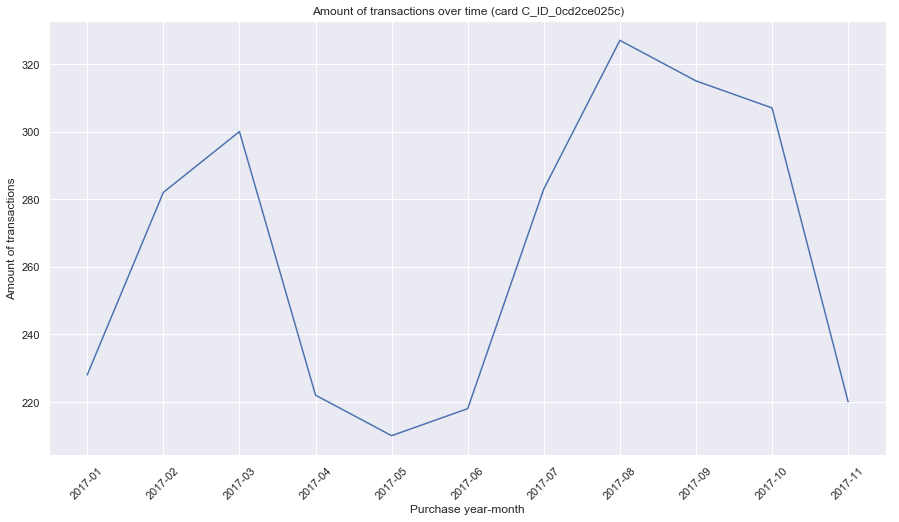

In [53]:
df_out2_nt = df_hist_trans[df_hist_trans['card_id']==id2].groupby('purchase_ym').size().reset_index().rename({0:'transactions'}, axis=1)
ax = sns.lineplot(x=df_out2_nt['purchase_ym'], y=df_out2_nt['transactions'], markers = True, dashes = False)
plt.xticks(rotation = 45)
ax.set_title('Amount of transactions over time (card ' + id2 + ')')
ax.set_xlabel('Purchase year-month')
ax.set_ylabel('Amount of transactions')

This user performs many transactions (more than 200 per month), but it doesn't seem to be anything strange. The target is also normal (around 0.11)

In [31]:
df_out2_trans = df_hist_trans[df_hist_trans['card_id']==id2]
print(('Percentage of denied transactions for card ' + id2 + ': {:.2f}%').format((df_out2_trans['authorized_flag'] == 'N').sum()/(df_out2_trans.shape[0])*100))

Percentage of denied transactions for card C_ID_0cd2ce025c: 12.88%


## Distribution of the purchase amount

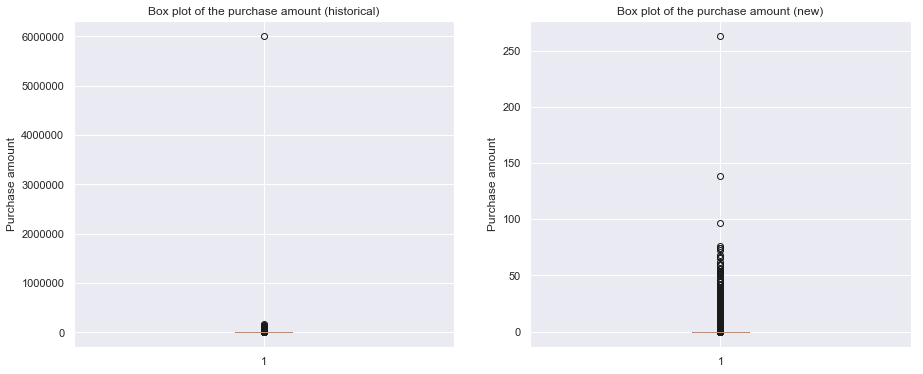

In [54]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.boxplot(df_hist_trans['purchase_amount'].values)
plt.title('Box plot of the purchase amount (historical)')
plt.ylabel('Purchase amount')

plt.subplot(1, 2, 2)
plt.boxplot(df_new_trans['purchase_amount'].values)
plt.title('Box plot of the purchase amount (new)')
plt.ylabel('Purchase amount')
plt.show()

So we see that there are a huge outlier in the historical set.

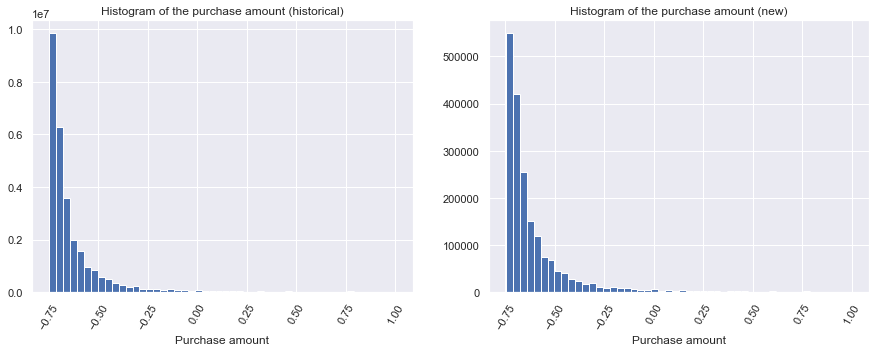

In [55]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df_hist_trans[df_hist_trans['purchase_amount']<1]['purchase_amount'].values, bins=50)
plt.title('Histogram of the purchase amount (historical)')
plt.xlabel('Purchase amount')
plt.xticks(rotation=60)

plt.subplot(1, 2, 2)
plt.hist(df_new_trans[df_new_trans['purchase_amount']<1]['purchase_amount'].values, bins=50)
plt.title('Histogram of the purchase amount (new)')
plt.xlabel('Purchase amount')
plt.xticks(rotation=60)
plt.show()

In order to see something from the histogram, we have to filter out all the transactions with a purchase amount greater then 1.

In [34]:
print(('Percentage of historical transactions with purchase_amount>1: {:.2f}%').format(df_hist_trans[df_hist_trans['purchase_amount']>1].shape[0]/df_hist_trans.shape[0]*100))
print(('Percentage of new transactions with purchase_amount>1: {:.2f}%').format(df_new_trans[df_new_trans['purchase_amount']>1].shape[0]/df_new_trans.shape[0]*100))

Percentage of historical transactions with purchase_amount>1: 1.19%
Percentage of new transactions with purchase_amount>1: 1.42%


### Largest value in the historical set

In [35]:
out_amount = df_hist_trans[df_hist_trans['purchase_amount']>6000000]
out_amount

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_ym
29050360,N,C_ID_3b6ac8e52d,69,N,0,A,683,M_ID_ee49262ab5,-3,6010604.0,2017-04-23 06:58:58,1.0,9,34,2017-04


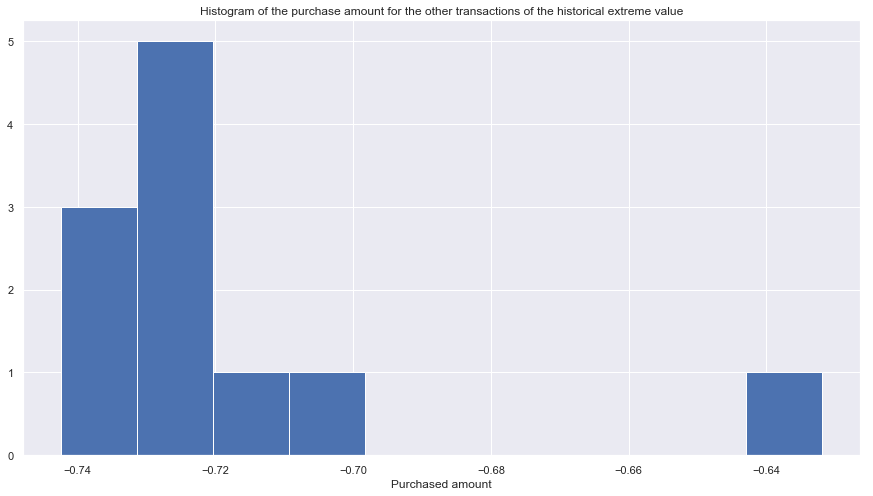

In [56]:
df_out_amount = df_hist_trans[df_hist_trans['card_id']==out_amount['card_id'].values[0]]
plt.hist(df_out_amount[df_out_amount['purchase_amount']<6000000]['purchase_amount'].values)
plt.title('Histogram of the purchase amount for the other transactions of the historical extreme value')
plt.xlabel('Purchased amount')
plt.show()

In [37]:
df_cards[df_cards['card_id']==out_amount['card_id'].values[0]]

,first_active_month,card_id,feature_1,feature_2,feature_3,target
74077,2017-04,C_ID_3b6ac8e52d,3,1,1,0.072539


We see that this extreme transaction was not authorized, and the other transactions of this same card seem normal, as well as the target of that card. So it might be an error and it should be marked as an **outlier**.

### Extreme values of purchase amount
Let's try to find out if the 1% of transactions with larger purchase amount have something in common.

In [38]:
df_hist_lamount = df_hist_trans[df_hist_trans['purchase_amount']>1]
print("{:} records in the historical set (extreme purchase amount)".format(df_hist_lamount.shape[0]))

347710 records in the historical set (extreme purchase amount)


In [39]:
df_new_lamount = df_new_trans[df_new_trans['purchase_amount']>1]
print("{:} records in the new set (extreme purchase amount)".format(df_new_lamount.shape[0]))

27796 records in the new set (extreme purchase amount)


In [40]:
print("Percentage of denied historical transactions with extreme purchase_amount: {:.2f}%".format(df_hist_lamount[df_hist_lamount['authorized_flag']!='Y'].shape[0]/df_hist_lamount.shape[0]*100))

Percentage of denied historical transactions with extreme purchase_amount: 26.11%


In the data set of new transactions there are no denied ones. Besides the percentage of denied transactions is larger than in the complete set. Thus, we will analyze just the accepted transactions.

In [41]:
df_hist_lamount = df_hist_lamount[df_hist_lamount['authorized_flag']!='Y']
print("{:} records in the historical set (accepted extreme purchase amount)".format(df_hist_lamount.shape[0]))

90791 records in the historical set (accepted extreme purchase amount)


In [42]:
print(('Percentage of users with some extreme purchase_amount historical transaction: {:.2f}%').format(df_hist_lamount['card_id'].nunique()/df_hist_trans['card_id'].nunique()*100))
print(('Percentage of users with some extreme purchase_amount new transaction: {:.2f}%').format(df_new_lamount['card_id'].nunique()/df_new_trans['card_id'].nunique()*100))

Percentage of users with some extreme purchase_amount historical transaction: 11.15%
Percentage of users with some extreme purchase_amount new transaction: 7.55%


Around 10% of the users have made an "extreme" accepted transaction at some point. Let's analyze these users (and one should also take a look at the merchants in which these transactions were performed).

In [43]:
ids = np.concatenate((df_hist_lamount['card_id'].unique(), df_new_lamount['card_id'].unique()))
df_cards_lamount = df_cards[df_cards['card_id'].isin(ids)]
df_cards_lamount.head(3)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749
31,2017-07,C_ID_ee82cdf108,5,2,1,-4.730778


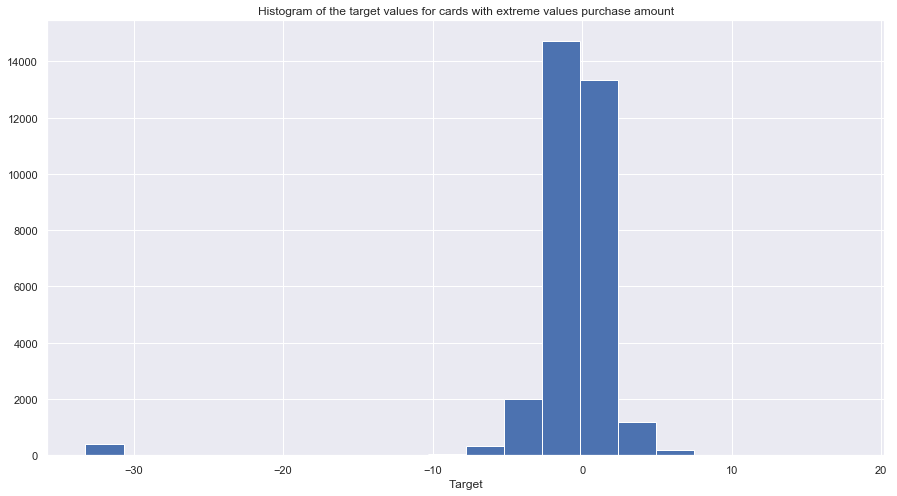

In [57]:
plt.hist(df_cards_lamount['target'].values, bins=20)
plt.title('Histogram of the target values for cards with extreme values purchase amount')
plt.xlabel('Target')
plt.show()

We see that there are some of the target outliers in this group.

In [45]:
print("Percentage of the target outliers corresponding with cards with extreme purchase_amount: {:.2f}%".format(df_cards_lamount[df_cards_lamount['target']<-30].shape[0]/df_cards[df_cards['target']<-30].shape[0]*100))
print("Percentage of the cards with extreme purchase_amount that have outlier target: {:.2f}%".format(df_cards_lamount[df_cards_lamount['target']<-30].shape[0]/df_cards_lamount.shape[0]*100))
print("Percentage of the cards with target outliers (in total): {:.2f}%".format(df_cards[df_cards['target']<-30].shape[0]/df_cards.shape[0]*100))

Percentage of the target outliers corresponding with cards with extreme purchase_amount: 17.54%
Percentage of the cards with extreme purchase_amount that have outlier target: 1.20%
Percentage of the cards with target outliers (in total): 1.09%


Since only around 10% of the users are represented in this extreme set, it seems that the proportion of users in this set with an outlier target is a bit larger. It could make sense taking into account the explanation given [in this kernel](https://www.kaggle.com/raddar/target-true-meaning-revealed), since a user that pays a big amount of money (maybe a big event) it likely not going to pay anymore in the same merchant. 

**target_wavg_purchase_date**: I would select a few merchants that are having relatively large number of transactions, and I would check how the distribution of their customers’ loyalty score look like.
- Is there any time-autocorrelation?
- Is there any correlation between amount and score?
- Is the st.mean error changing if we select customers with many other purchases, vs customers with only a few other merchant relations.